# Validate BayesFlow Posterior with MCMC

In this notebook we are going to validate the posterior from BayesFlow by comparing it to posteriors generated from MCMC.

In [1]:
import os
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from numba import njit
from pypesto import sample, optimize, visualize, FD, Objective, Problem, store
from scipy import stats
from tqdm import tqdm
from inference.likelihoods import log_likelihood_additive_noise, log_likelihood_multiplicative_noise

In [2]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'pharmacokinetic_model', 'clairon_small_model'][1]
network_idx = 0
load_best_network = True

## Load individual model


In [ ]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple, batch_simulator
    model = FroehlichModelSimple(network_idx=network_idx, load_best=load_best_network)
    
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed, batch_simulator
    model = FroehlichModelDetailed(network_idx=network_idx, load_best=load_best_network)

elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel, batch_simulator, convert_bf_to_observables
    model = PharmacokineticModel(network_idx=network_idx, load_best=load_best_network)
    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel, batch_simulator, convert_bf_to_observables
    prior_type = ['normal', 'uniform'][0]
    model = ClaironSmallModel(network_idx=network_idx, load_best=load_best_network, prior_type=prior_type)
else:
    raise NotImplementedError('model not implemented')

# load network
trainer = model.build_trainer('../networks/' + model.network_name)

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load Data

In [ ]:
# load synthetic data for specific model
load_synthetic = True
obs_data = model.load_data(synthetic=load_synthetic)

# chose 10 random individuals/cells
np.random.seed(42)
individual_ids = np.random.randint(0, len(obs_data), size=10)  # obs_data can be list or numpy array
obs_data = [obs_data[i] for i in individual_ids]
    

if load_synthetic:
    # for these model parameters are known
    if model_name == 'fröhlich-sde':
        cell_param_log = pd.read_csv(f'../data/synthetic/synthetic_individual_cell_params_sde_model.csv',
                                     index_col=0, header=0)
    elif model_name == 'fröhlich-detailed':
        cell_param_log = pd.read_csv(f'../data/synthetic/synthetic_individual_cell_params_detailed_model.csv',
                                     index_col=0, header=0)
    else:
        cell_param_log = pd.read_csv(f'../data/synthetic/synthetic_individual_cell_params.csv',
                                     index_col=0, header=0)
        
    cell_param_log = cell_param_log.iloc[individual_ids]

## Examine Posterior for a Single Individual/Cell

In [ ]:
# use observations to get a first look at the posterior
n_bayesflow_samples = 10000
obs_data_posterior_samples = model.draw_posterior_samples(data=obs_data, n_samples=n_bayesflow_samples)

In [ ]:
rows = 3
fig, ax = plt.subplots(rows, int(np.ceil(len(obs_data) / rows)), tight_layout=True, figsize=(10, rows*3),
                       sharex='row', sharey='all')
axis = ax.flatten()
    
for p_id in tqdm(range(len(obs_data))):
    axis[p_id] = model.prepare_plotting(obs_data[p_id], obs_data_posterior_samples[p_id, :100], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()
    
for _ax in axis[len(obs_data):]:
    _ax.remove()

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1))
plt.show()

## Prepare MCMC Posterior

First we need to define the likelihood and the prior we want to use for MCMC.
Note: BayesFlow works without specifying a likelihood since it is a simulation-based method.

In [ ]:
@njit
def log_prior_density_normal(log_param: np.ndarray, 
                             mean: np.ndarray,
                             inv_cov_matrix: np.ndarray, 
                             prior_constant: float) -> float:
    # compute the log normal density of the prior
    dif = log_param - mean
    return prior_constant - 0.5 * dif.dot(inv_cov_matrix).dot(dif.T) # - log_param.sum()  sum cancels with log-transformation

@njit
def log_prior_density_uniform(log_param: np.ndarray, 
                              prior_bounds: np.ndarray) -> float:
    # check if parameters are within bounds
    if np.any(log_param < prior_bounds[:, 0]) or np.any(log_param > prior_bounds[:, 1]):
        return -np.inf
    # compute the log uniform density of the prior
    constant = -np.log(np.diff(prior_bounds).prod())
    return constant

if model.prior_type == 'normal':
    _, logabsdet = np.linalg.slogdet(model.prior_cov)
    log_prior_constant = -0.5 * model.n_params * np.log(2 * np.pi) -0.5* logabsdet
    inv_cov = np.linalg.inv(model.prior_cov)

In [ ]:
individual_id = 0  # patient 5 for pharma, fro-detailed 0
obs_data_indv = obs_data[individual_id]

In [ ]:
# prepare simulator accordingly to the model
if 'Froehlich' in model.name :
    # prepare simulator, data should be on log-scale
    simulator = partial(batch_simulator, 
                                n_obs=180,
                                with_noise=False)
    noise_model = 'multiplicative'  # additive on log-scale 
    index_sigma = -1  # index of sigma in parameter vector
    obs_data_indv_prepared = obs_data_indv.flatten()  # just one measurement per time point, already on log-scale
elif 'Pharma' in model.name:
    # prepare simulator, data should be on log-scale
    obs_data_indv_prepared, t_measurement, doses_time_points, dos, wt = convert_bf_to_observables(obs_data_indv)
    simulator = partial(batch_simulator,
                       t_measurement=t_measurement,
                       t_doses=doses_time_points,
                       wt=wt,
                       dos=dos,
                       with_noise=False,
                       convert_to_bf_batch=False)
    noise_model = 'multiplicative'  # additive on log-scale
    index_sigma = [-3, -2]  # index of sigmas in parameter vector
elif 'Clairon' in model.name:
    # prepare simulator, data should be on linear scale
    obs_data_indv_prepared, t_measurements, doses_time_points, dose_amount = convert_bf_to_observables(obs_data_indv)
    simulator = partial(batch_simulator,
                        t_measurements=t_measurements,
                        t_doses=doses_time_points,
                        with_noise=False,
                        convert_to_bf_batch=False)    
    noise_model = 'proportional'   # additive on linear scale
    index_sigma = [-2, -1]  # index of a, b in parameter vector of y+(a+by)*e
else:
    raise NotImplementedError('model not implemented')

assert simulator(model.prior_mean).shape == obs_data_indv_prepared.shape, 'simulator output shape does not match data shape' 

In [ ]:
def neg_log_prop_posterior(log_param: np.ndarray):
    y_sim = simulator(log_param)  
    if noise_model == 'multiplicative':
        llh = log_likelihood_multiplicative_noise(log_measurements=obs_data_indv_prepared,
                                                  log_simulations=y_sim,
                                                  sigmas=np.exp(log_param[index_sigma]))
    else:  # noise_model == 'proportional':
        prop_sigma =  np.exp(log_param[index_sigma[0]]) + obs_data_indv_prepared * np.exp(log_param[index_sigma[1]])
        llh = log_likelihood_additive_noise(measurements=obs_data_indv_prepared,
                                            simulations=y_sim,
                                            sigmas=prop_sigma)
        
    if model.prior_type == 'normal':
        log_prior = log_prior_density_normal(log_param=log_param, mean=model.prior_mean, inv_cov_matrix=inv_cov,
                                             prior_constant=log_prior_constant)
    else:
        log_prior = log_prior_density_uniform(log_param=log_param, prior_bounds=model.prior_bounds)
    return -(llh + log_prior)

## Run MCMC

In [ ]:
from pypesto.objective import NegLogParameterPriors

n_chains = 10
n_samples = 1e5
filename = f'sampling_results/mcmc_{model.name}_individual_{individual_id}_synthetic.hdf5'

# create objective function
pesto_objective = FD(obj=Objective(fun=neg_log_prop_posterior),
                     x_names=model.log_param_names)

lb = model.prior_mean - 5 * model.prior_std
ub = model.prior_mean + 5 * model.prior_std

x_priors_defs = NegLogParameterPriors(
    [{'index': i, 'density_fun': lambda x: -stats.norm.logpdf(x, loc=model.prior_mean[i], scale=np.sqrt(model.prior_cov.diagonal()[i]))}
     for i in range(model.n_params)])

# create pypesto problem
pesto_problem = Problem(objective=pesto_objective,
                        lb=lb, ub=ub,
                        x_names=model.log_param_names,
                        x_priors_defs=x_priors_defs,
                        x_scales=['log']*len(model.log_param_names))
pesto_problem.print_parameter_summary()

In [72]:
# check if file exists, if not run optimization
if os.path.exists(filename):
    result = store.read_result(filename)
else:
    result = optimize.minimize(problem=pesto_problem,
                           optimizer=optimize.ScipyOptimizer(),
                           n_starts=n_chains)

This problem is not to be used without a separately created objective.
INFO:pypesto.store.read_from_hdf5:WARNING: You are loading a problem.
This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within sampling_results/mcmc_DetailedFroehlichModel_individual_0_synthetic.hdf5.


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/keras/src/backend.py", line 5158, in <genexpr>
    output_ta_t = tuple(  File "/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


1463.5845555457197


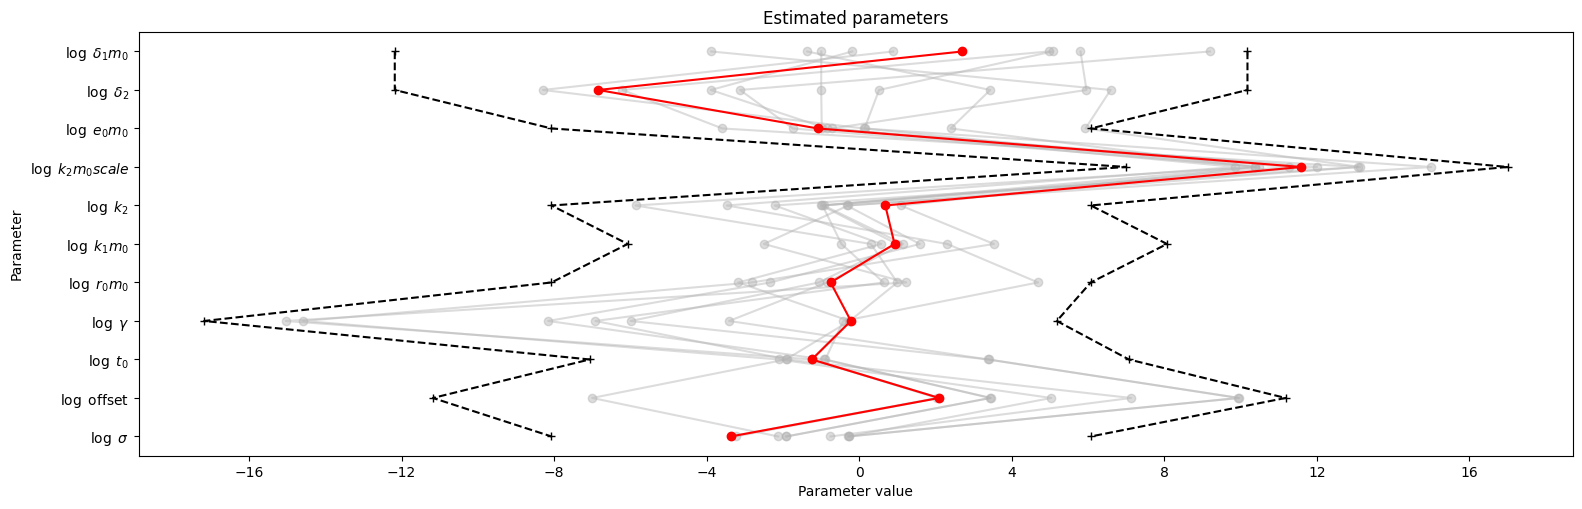

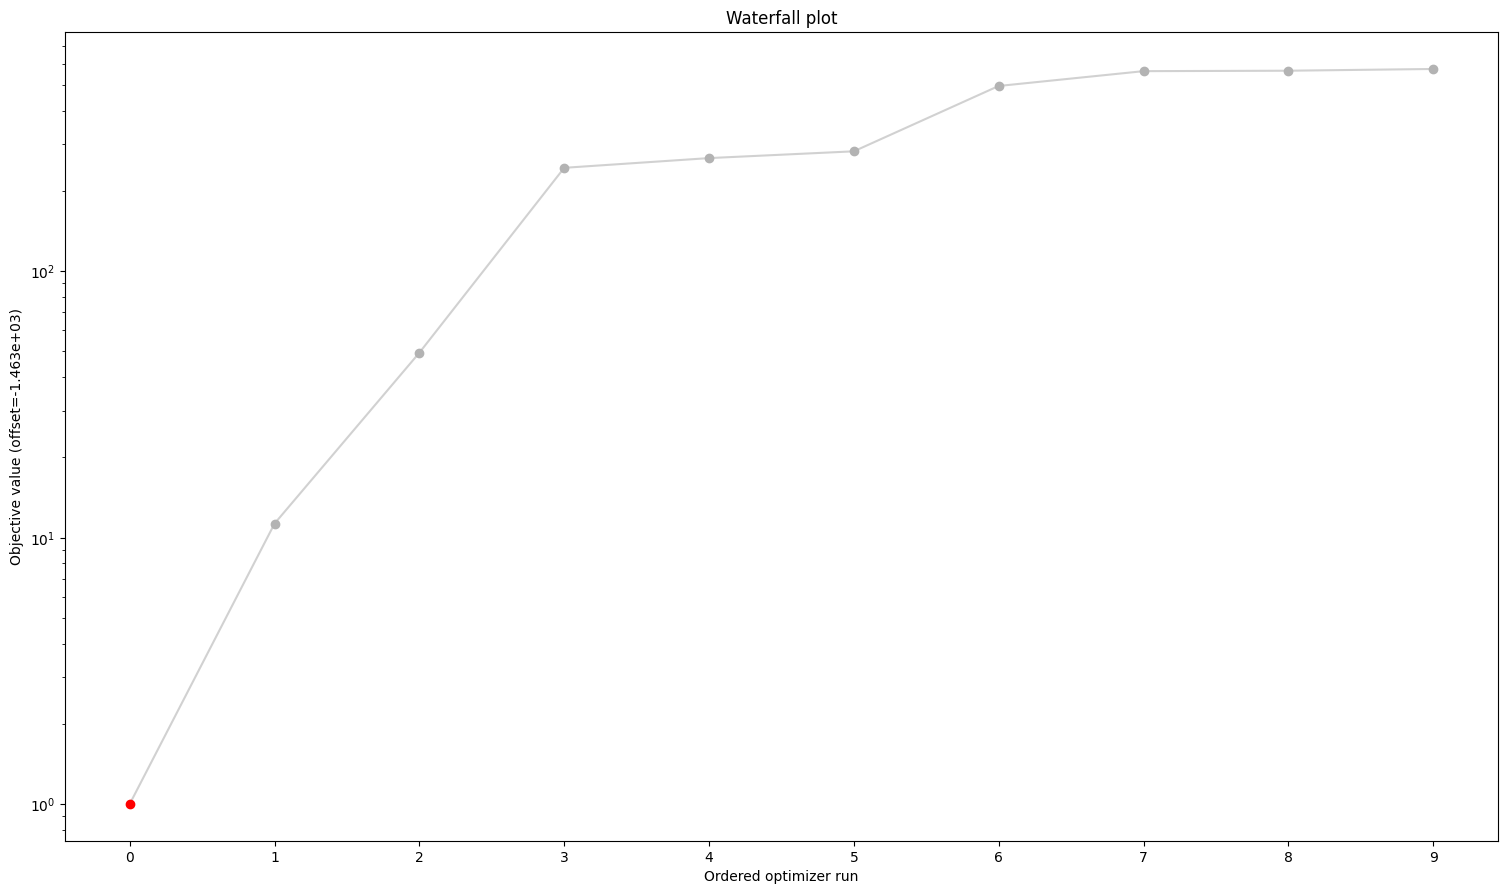

In [73]:
visualize.parameters(result)
visualize.waterfall(result)
print(neg_log_prop_posterior(result.optimize_result.x[0]))

100%|██████████| 6/6 [00:00<00:00, 335.33it/s]


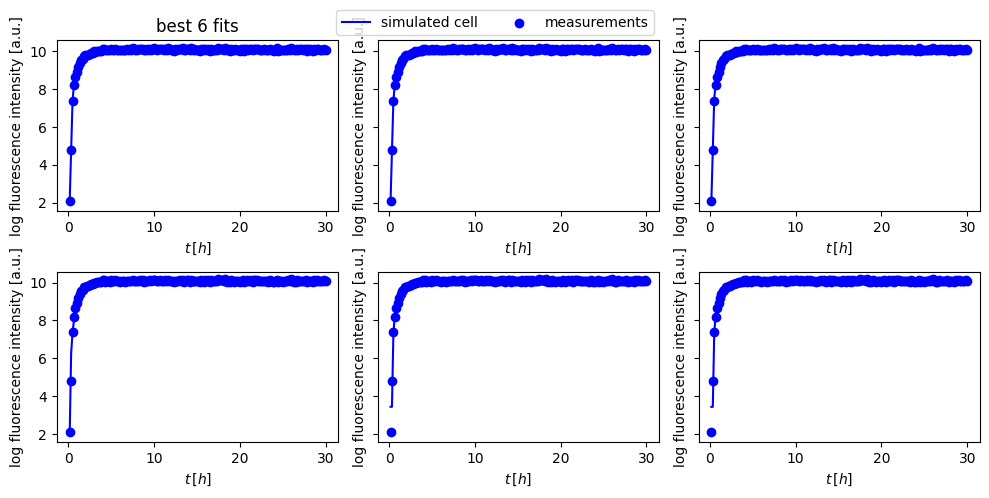

In [74]:
fig, ax = plt.subplots(2, 3, tight_layout=True, figsize=(10, 5),
                       sharex='row', sharey='all')
axis = ax.flatten()
    
for p_id in tqdm(range(axis.size)):
    axis[p_id] = model.prepare_plotting(obs_data_indv, result.optimize_result.x[p_id], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1))
axis[0].set_title(f'best {axis.size} fits')
plt.show()

In [45]:
def llh(log_param: np.ndarray):
    y_sim = simulator(log_param)  
    return log_likelihood_multiplicative_noise(log_measurements=obs_data_indv_prepared,
                                                  log_simulations=y_sim,
                                                  sigmas=np.exp(log_param[index_sigma]))

In [88]:
# rejection sampling
n_samples = 1000
accepted_samples = []
max_iter = 100000
i = 0
log_M = llh(result.optimize_result.x[0]) #+ 100

while len(accepted_samples) < n_samples:
    i += 1
    #sample = model.draw_posterior_samples(data=obs_data_indv, n_samples=1).flatten()
    samples = model.prior(1)['prior_draws'].flatten()
    log_prop = llh(samples)  # posterior / prior
    
    log_uni = np.log(np.random.uniform(0, 1))
    if log_uni <= log_prop - log_M:
        accepted_samples.append(samples)
        print(f'accepted {len(accepted_samples)/i*100} % of samples')   
    
    if i > max_iter:
        print('max iterations reached')
        break
print(f'Final: accepted {len(accepted_samples)/i} % of samples')  

max iterations reached
Final: accepted 0.0 % of samples


In [87]:
log_M

-1437.0099079614702

In [76]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=n_chains,
)

In [77]:
x0 = list(result.optimize_result.x)[:n_chains]
if model_name == 'fröhlich-simple':
    x1 = x0[0].copy()
    x2 = x0[0].copy()
    
    x2[0] = x1[1]
    x2[1] = x1[0]
    
    x0 = [x1, x2] * (n_chains //2 )
    
    print(pesto_problem.objective(x1)-pesto_problem.objective(x2))

In [78]:
# sample uniform from prior
#x0 = list(model.prior(n_chains)['prior_draws'])

In [79]:
if not os.path.exists(filename):
    result = sample.sample(
            pesto_problem, n_samples=n_samples, sampler=sampler,
            filename=filename,
            x0=x0,
            result=result)

In [80]:
geweke_test = sample.geweke_test(result)
auto_correlation = sample.auto_correlation(result)
effective_sample_size = sample.effective_sample_size(result)

Geweke burn-in index: 90000
INFO:pypesto.sample.diagnostics:Geweke burn-in index: 90000
Estimated chain autocorrelation: 302.3032224447
INFO:pypesto.sample.diagnostics:Estimated chain autocorrelation: 302.3032224447
Estimated effective sample size: 32.9736028499448
INFO:pypesto.sample.diagnostics:Estimated effective sample size: 32.9736028499448


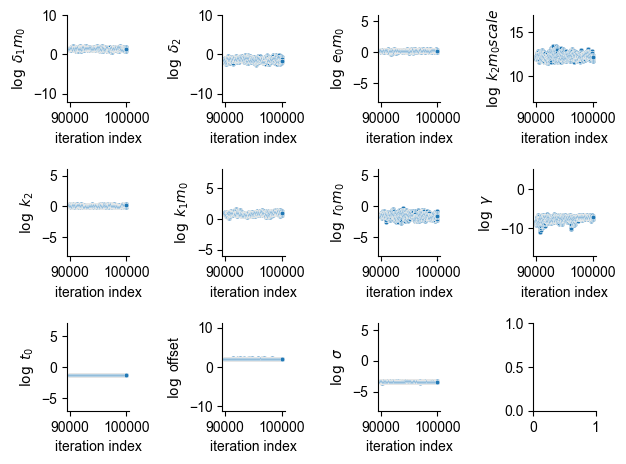

In [81]:
visualize.sampling_parameter_traces(result, use_problem_bounds=True);

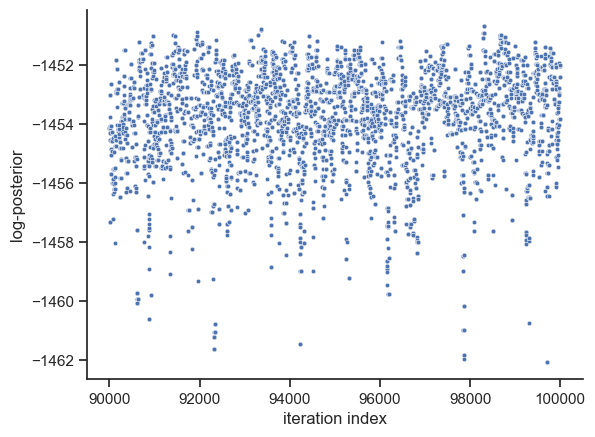

In [82]:
visualize.sampling_fval_traces(result);

In [83]:
if not os.path.exists(filename):
    store.write_result(
            result=result,
            filename=filename,
            problem=True,
            optimize=True,
            sample=True,
    )

In [84]:
pesto_samples = result.sample_result.trace_x[0]
print(pesto_samples.shape)

(100001, 11)


In [85]:
burn_in = result.sample_result.burn_in
pesto_samples_adjusted = pesto_samples[burn_in:, :]
print(pesto_samples_adjusted.shape)

(10001, 11)


In [86]:
MAP_idx = np.argmin(result.sample_result.trace_neglogpost[0,burn_in:])
MAP = result.sample_result.trace_x[0,burn_in+MAP_idx,:]
print('MAP (optimizing)', neg_log_prop_posterior(result.optimize_result.x[0]))
print('MAP (sampling)', neg_log_prop_posterior(MAP))

if model_name == 'fröhlich-simple':
    # it is known, that this model's posterior should have two modes (in the first two parameters)
    other_MAP = MAP.copy()
    other_MAP[[0,1]] = other_MAP[[1,0]]
    print('MAP-2 (sampling)', neg_log_prop_posterior(other_MAP))

MAP (optimizing) 1463.5845555457197
MAP (sampling) 1450.6804480896203


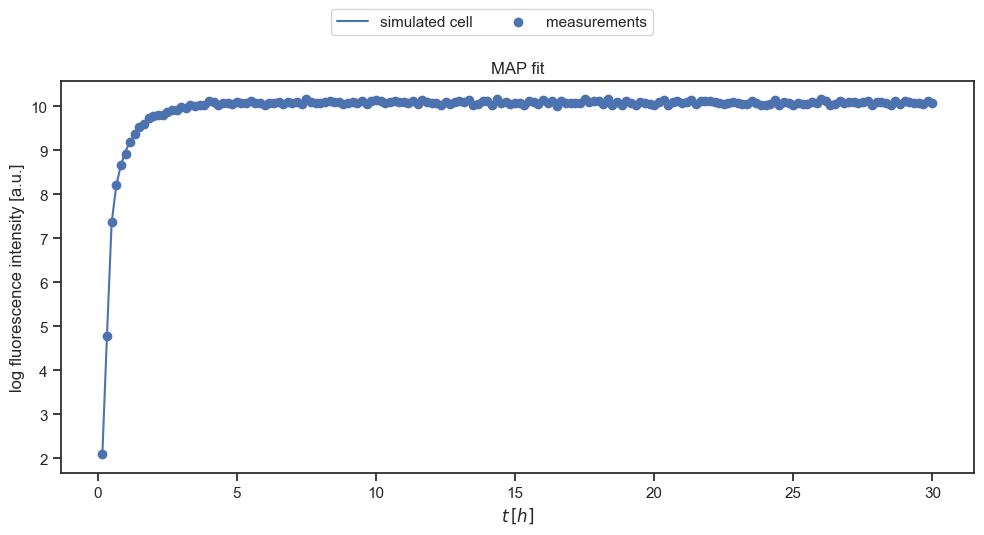

In [26]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))

ax = model.prepare_plotting(obs_data_indv, MAP, ax)
_, labels = ax.get_legend_handles_labels()
fig.legend(labels, ncol=4, loc='lower center', bbox_to_anchor=(0.5, 1))

ax.set_title(f'MAP fit')
plt.show()

# Compare BayesFlow and MCMC

In [27]:
plt.rcParams.update({'font.size': 20,
                     'text.usetex': True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern Roman"],
                     'axes.titlesize': 'small',
                     'axes.labelsize': 'small',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small',
                     'legend.fontsize': 'small',
                     #'figure.dpi': 600,
                     'figure.figsize': (16,9)}) #
colors = ['#1f78b4', '#a6cee3', '#b2df8a','#33a02c','#fb9a99']

In [28]:
# reduce to same number of samples
n_samples = min(obs_data_posterior_samples[individual_id].shape[0], pesto_samples_adjusted.shape[0])
bayes_flow_samples = obs_data_posterior_samples[individual_id]
mcmc_smaples = pesto_samples_adjusted#[np.random.choice(range(pesto_samples_adjusted.shape[0]),
                                      #                 n_samples, replace=False)]

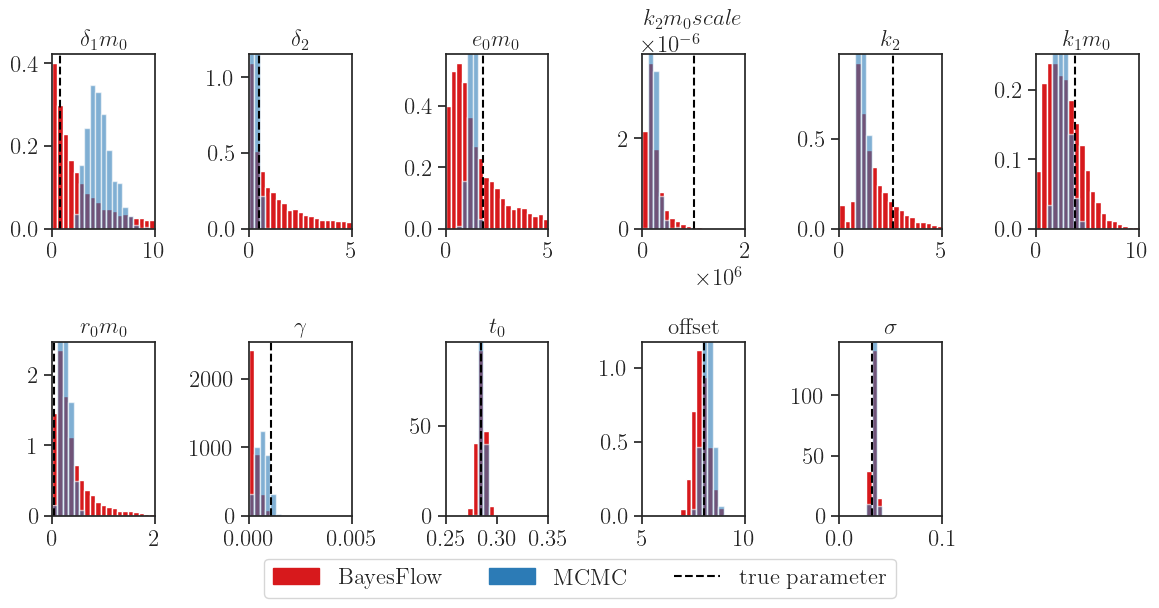

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(model.n_params/2)), tight_layout=True, figsize=(12,6))
axis = ax.flatten()
bins = 20
binwidth = 0.5
if model.name == 'DetailedFroehlichModel':
    xlim = [[0,10], [0,5], [0,5], [0,2*1e+6], [0,5], [0,10], [0,2], [0,0.005], [0.25,0.35], [5,10], [0,0.1]]
else:
    xlim = [[-0.1,0.5], [-0.1,0.5], [300,600], [0, 2], [5,10], [0,0.1]]
    
for i, name in enumerate(model.param_names):
    axis[i].set_title(name) #'log '+name)
    axis[i].hist(np.exp(bayes_flow_samples[:, i]), 
                 bins=np.linspace(xlim[i][0], xlim[i][1], bins), #bins,
                 density=True, label='BayesFlow', color='#d7191c') #
    ylim = axis[i].get_ylim()
    #xlim = axis[i].get_xlim()

    axis[i].hist(np.exp(mcmc_smaples[:, i]), 
                 bins=np.linspace(xlim[i][0], xlim[i][1], bins),
                 #bins=np.arange(min(np.exp(mcmc_smaples[:, i])), max(np.exp(mcmc_smaples[:, i])) + binwidth, binwidth),
                 density=True, label='MCMC', alpha=0.6, color='#2c7bb6')
    axis[i].set_ylim(ylim)
    
    
    if model.prior_type == 'normal':
        #x_prior = np.linspace(model.prior_mean[i] - 0.1*model.prior_std[i], 
         #           model.prior_mean[i] + 0.1*model.prior_std[i], 1000)
        #prior_density = stats.norm.pdf(x_prior, model.prior_mean[i], model.prior_std[i])
        #prior_handle, = axis[i].plot(np.exp(x_prior), prior_density, color='orange', label='Prior',
        #                             linestyle='-')
        # set axis to lim without prior 
        pass #axis[i].set_xlim(xlim)
    elif model.prior_type == 'uniform':
        axis[i].set_xlim(np.exp(model.prior_bounds[i]))
     
    true_value = axis[i].axvline(np.exp(cell_param_log.values[individual_id][i]), linestyle='--', color='black',
                                 label='true parameter') 
    
    true_param = np.exp(cell_param_log.values[individual_id][i])
    #xlim = true_param -0.5*true_param, true_param+0.5*true_param
    #xlim = -1, np.exp(cell_param_log.values[individual_id][i])+1
    axis[i].set_xlim(xlim[i])
    
bf_handle = mpatches.Patch(color='#d7191c', label='BayesFlow')
mcmc_handle = mpatches.Patch(color='#2c7bb6', label='MCMC')
lgd = fig.legend(handles=[bf_handle, mcmc_handle, true_value], ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.05))

for _ax in axis[model.n_params:]:
    _ax.remove()
#plt.savefig(f'../plots/posterior_validation_{model.name}_individual_{individual_id}_synthetic.pdf', format='pdf',
#            bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

In [83]:
def prepare_plotting(data: np.ndarray, params: np.ndarray, ax: plt.Axes = None,
                         with_noise: bool = False) -> plt.Axes:
        # simulate data
        sim_data = batch_simulator(param_batch=params, n_obs=180, with_noise=with_noise)
        t_measurement = np.linspace(start=1 / 6, stop=30, num=180, endpoint=True)

        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)

        if len(params.shape) == 1:  # so not (batch_size, params)
            # just a single parameter set
            # plot simulated data
            ax.plot(t_measurement, sim_data, 'b', label='simulated cell')
        else:
            # remove channel dimension of bayesflow
            sim_data = sim_data[:, :, 0]
            # calculate median and quantiles
            y_median = np.median(sim_data, axis=0)
            y_quantiles = np.percentile(sim_data, [2.5, 97.5], axis=0)

            # plot simulated data
            ax.fill_between(t_measurement, y_quantiles[0], y_quantiles[1],
                            alpha=0.2, color='b', label='$95\\%$ quantiles')
            ax.plot(t_measurement, y_median, 'b', label='median')

        # plot observed data
        ax.scatter(t_measurement, data, color='b', label='measurements')
        ax.set_xlabel('$t\, [h]$')
        ax.set_ylabel('log fluorescence intensity [a.u.]')
        return ax

In [84]:
sim_data = batch_simulator(param_batch=obs_data_posterior_samples[individual_id], n_obs=180, with_noise=True)
sim_data_MCMC = batch_simulator(param_batch=mcmc_smaples, n_obs=180, with_noise=True)

In [85]:
sim_data = np.median(sim_data, axis=0)
sim_data.sort()
sim_data_MCMC = np.median(sim_data_MCMC, axis=0)
sim_data_MCMC.sort()

In [86]:
sim_data_MCMC.shape

(180, 1)

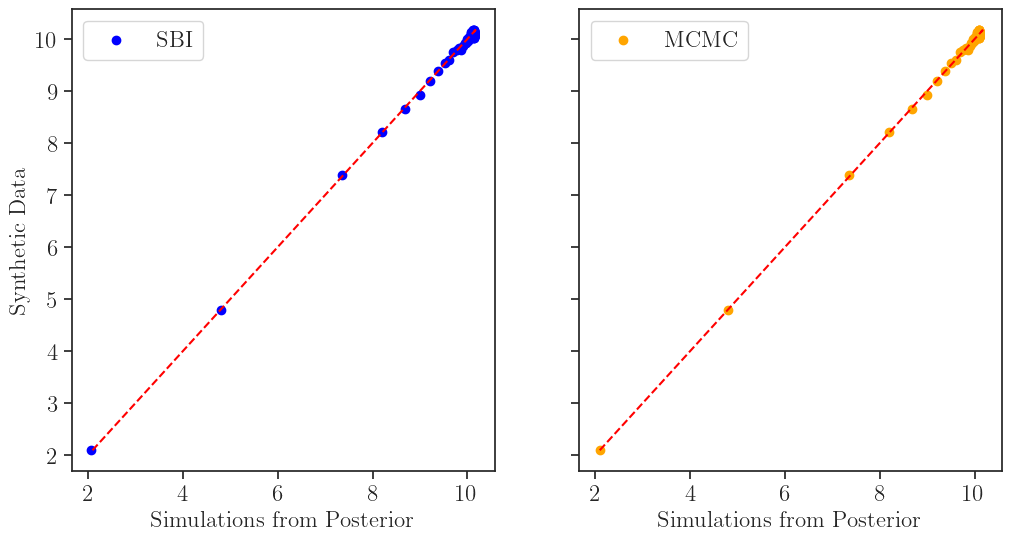

In [87]:
# Create Q-Q plot
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6), sharey=True)
ax[0].scatter(sim_data, obs_data_indv, marker='o', color='blue', label='SBI')
ax[1].scatter(sim_data_MCMC, obs_data_indv, marker='o', color='orange', label='MCMC')

#plt.scatter(sim_a3, real_data_a3, color='green', edgecolors='black', alpha=0.6)
ax[0].plot(obs_data_indv, obs_data_indv, color='red', linestyle='--')
ax[1].plot(obs_data_indv, obs_data_indv, color='red', linestyle='--')
#ax[0].set_title('Q-Q Plot - A2')
ax[0].set_ylabel('Synthetic Data')
ax[0].set_xlabel('Simulations from Posterior')
ax[1].set_xlabel('Simulations from Posterior')

for a in ax:
    a.legend()

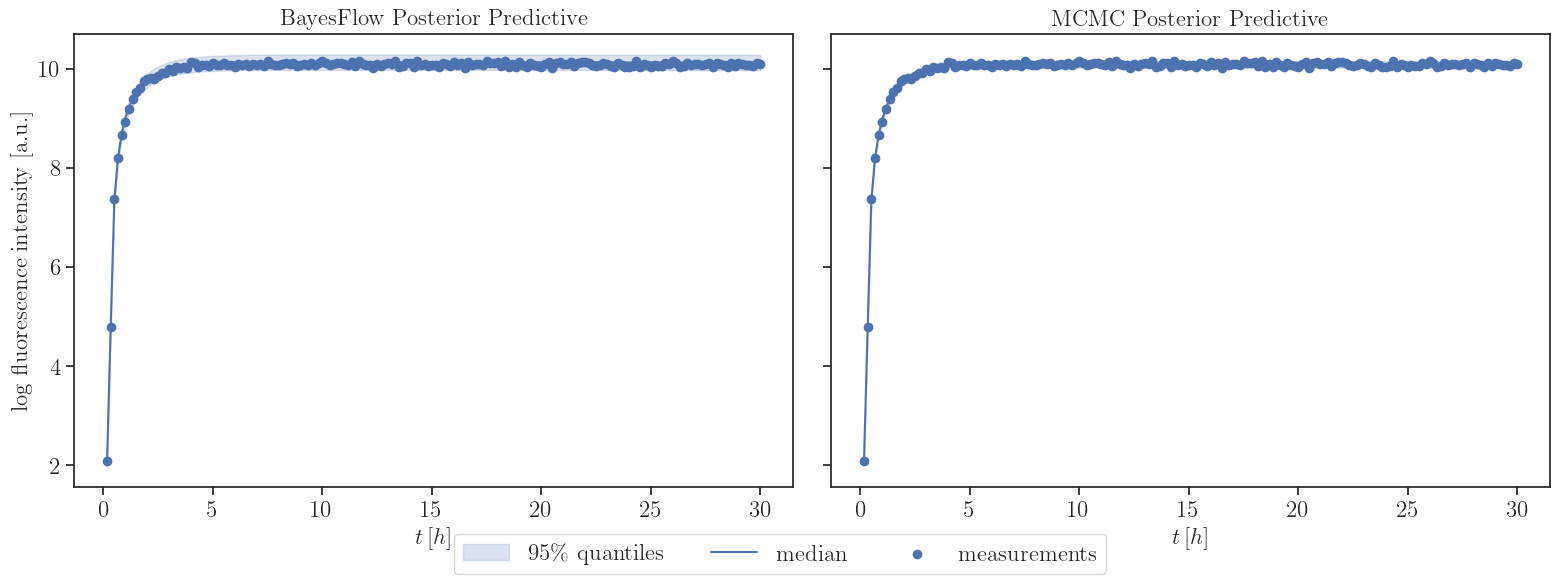

In [89]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(16, 6),
                       sharex='row', sharey='all')
    
ax[0] = prepare_plotting(obs_data_indv, obs_data_posterior_samples[individual_id], ax[0], with_noise=False)
ax[1] = prepare_plotting(obs_data_indv, mcmc_smaples, ax[1], with_noise=True)
_, labels = ax[0].get_legend_handles_labels()
ax[1].set_ylabel('')

fig.legend(labels, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.01))
ax[0].set_title('BayesFlow Posterior Predictive')
ax[1].set_title('MCMC Posterior Predictive')
#plt.savefig(f'../plots/mcmc/posterior_simulation_{model.name}_individual_{individual_id}.png', dpi=600)
plt.savefig(f'../plots/posterior_simulation_{model.name}_individual_{individual_id}.png', dpi=600)
plt.show()

In [ ]:
# estimate noise
if 'Froehlich' in model.name:
    var_bayes = 1/(obs_data_indv.shape[0]-1)*np.sum((np.median(batch_simulator(obs_data_posterior_samples[individual_id], with_noise=False), axis=0).flatten()-obs_data_indv.T)**2)
    print(var_bayes, np.exp(np.median(obs_data_posterior_samples[individual_id, :, -1]))**2)
    
    var_bayes = 1/(obs_data_indv.shape[0]-1)*np.sum((np.median(batch_simulator(mcmc_smaples, with_noise=False), axis=0).flatten()-obs_data_indv.T)**2)
    print(var_bayes, np.exp(np.median(mcmc_smaples[:, -1]))**2)

## Dimensionality Reduction

To see visually if samples differ, we map the posterior samples in a two-dimensional space using a UMAP. 

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler

In [ ]:
prior_samples = model.prior(n_samples)['prior_draws']

In [ ]:
# normalize samples
all_samples = np.concatenate((bayes_flow_samples, mcmc_smaples, prior_samples), axis=0)
scaled_samples = StandardScaler().fit_transform(all_samples)

# create umap
reducer = umap.UMAP(random_state=42, n_jobs=1,   # for reproducibility 
                    densmap=True,  # preserve local density
                    ) 
umap_embedding = reducer.fit_transform(scaled_samples)

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(8, 6))
plt.scatter(
    umap_embedding[bayes_flow_samples.shape[0]+mcmc_smaples.shape[0]:, 0],
    umap_embedding[bayes_flow_samples.shape[0]+mcmc_smaples.shape[0]:, 1], 
    label='Prior', alpha=0.3, color='orange')
plt.scatter(
    umap_embedding[:bayes_flow_samples.shape[0], 0],
    umap_embedding[:bayes_flow_samples.shape[0], 1], 
    label='BayesFlow', alpha=1, color='blue')
plt.scatter(
    umap_embedding[bayes_flow_samples.shape[0]:bayes_flow_samples.shape[0]+mcmc_smaples.shape[0], 0],
    umap_embedding[bayes_flow_samples.shape[0]:bayes_flow_samples.shape[0]+mcmc_smaples.shape[0], 1], 
    label='MCMC', alpha=0.3, color='red')
plt.legend()
plt.title('Umap Based Representation of Posterior Distributions')

#plt.savefig(f'../plots/mcmc/posterior_umap_{model.name}_individual_{individual_id}.png', dpi=600)
plt.show()

In [ ]:
# normalize samples without sigma
all_samples = np.concatenate((bayes_flow_samples[:, :-2], mcmc_smaples[:, :-2], prior_samples[:, :-2]), axis=0)
scaled_samples = StandardScaler().fit_transform(all_samples)

# create umap
reducer = umap.UMAP(random_state=42, n_jobs=1,  # for reproducibility 
                    densmap=True,  # preserve local density
                    )
umap_embedding = reducer.fit_transform(scaled_samples)

fig = plt.figure(tight_layout=True, figsize=(8, 6))
plt.scatter(
    umap_embedding[bayes_flow_samples.shape[0]+mcmc_smaples.shape[0]:, 0],
    umap_embedding[bayes_flow_samples.shape[0]+mcmc_smaples.shape[0]:, 1], 
    label='Prior', alpha=0.3, color='orange')
plt.scatter(
    umap_embedding[:bayes_flow_samples.shape[0], 0],
    umap_embedding[:bayes_flow_samples.shape[0], 1], 
    label='BayesFlow', alpha=1, color='blue')
plt.scatter(
    umap_embedding[bayes_flow_samples.shape[0]:bayes_flow_samples.shape[0]+mcmc_smaples.shape[0], 0],
    umap_embedding[bayes_flow_samples.shape[0]:bayes_flow_samples.shape[0]+mcmc_smaples.shape[0], 1], 
    label='MCMC', alpha=0.3, color='red')
plt.legend()
plt.title('Umap Based Representation of Posterior Distributions')

plt.savefig(f'../plots/mcmc/posterior_umap_reduced_{model.name}_individual_{individual_id}.png', dpi=600)
plt.show()

# test 

In [ ]:
repeats = 100
noise_level = 0.1
for index in range(model.n_params):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6),
                       sharex='row', sharey='all')
    plt.title(f'Simulations - only changing {model.param_names[index]} - std={noise_level}')
    test = np.zeros(model.n_params)
    test[index] = 1
    #test[2] = 1
    test = np.repeat(test[np.newaxis, :], repeats=repeats, axis=0) * np.random.normal(0, noise_level, (repeats, 7))
    ax = model.prepare_plotting(obs_data_indv, mcmc_smaples.mean(axis=0) + test, ax, with_noise=True)
    _, labels = ax.get_legend_handles_labels()
    #plt.savefig(f'../plots/simulations_changing_{model.param_names[index]}_{noise_level}.png', dpi=600)
    plt.show()

In [ ]:
repeats = 2
noise_level = 0.1
test_index = 3
test = mcmc_smaples.mean(axis=0).copy()
for index in range(model.n_params):
    if index == test_index:
        continue
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 6),
                       sharex='row', sharey='all')
    ax[0].set_title(f'Simulations - changing {model.param_names[index]}- std={noise_level}')
    #test = np.zeros(model.n_params)
    #test[index] = 0.1
    #test[test_index] = -0.5
    #test = np.repeat(test[np.newaxis, :], repeats=repeats, axis=0) #* np.random.normal(0, noise_level, (repeats, 7))
    ax[0] = model.prepare_plotting(obs_data_indv, test, ax[0], with_noise=True)
    _, labels = ax[0].get_legend_handles_labels()
    #plt.savefig(f'../plots/simulations_changing_{model.param_names[index]}_{noise_level}.png', dpi=600)
    
    test_2 = test.copy()
    test_2[index] += 0.1
    test_2[test_index] += 1
#    ax[1].set_title(f'Parameter switched {model.param_names[test_index]}')
    ax[1] = model.prepare_plotting(obs_data_indv, test_2, ax[1], with_noise=True)
    plt.show()
    
# 0, 2 above
# 3 below